<a href="https://colab.research.google.com/github/p25-c4/car/blob/main/0309_DT_completed_car_project_KH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy import stats

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant

# Load the Data

In [ ]:
# df = pd.read_csv("data/data2/Car.csv")
# df.head()

In [ ]:
## 단위 제거
# df['Engine'] = pd.to_numeric(df['Engine'].replace(' CC', "", regex=True),errors = 'coerce')
# df['Mileage'] = pd.to_numeric(df['Mileage'].replace(' kmpl', "", regex=True),errors = 'coerce')
# df['Power'] = pd.to_numeric(df['Power'].replace(' bhp', "", regex=True),errors = 'coerce')

## Name에서 Brand 추출
# df['Brand'] = df['Name'].str.split().str[0]

# df.head()

In [ ]:
# df.to_csv("car_used.csv", index=False)

In [ ]:
df = pd.read_csv("car_used.csv")
df.head()
df.shape

(7253, 14)

In [ ]:
df['Mileage'].max()

33.54

# EDA & Preprocessing

- 데이터 전처리 항목
    1. Owner_Type: 숫자형으로 변환, 4 이상은 4로 처리
        - 4 이상인 자료가 12개 밖에 되지 않아 4로 처리함
   
    2. Name -> Brand: 국가(대륙) 별로 feature 추가
        - Brand별 가격 차이가 있을 것으로 생각해 Brand feature 추가
        - 비슷한 국가, 대륙의 Brand 가격이 비슷할 것으로 생각하여 국가(대륙)별로 묶으려 하였으나, 데이터를 살펴본 결과 그렇지 않아서 그룹화 기준 변경
        - Brand에 따른 가격의 median을 내림차순 정렬하여 적절한 선에서 4가지 그룹으로 파생변수 Brand_level 생성
   
    3. Location: 지역별 가격 차이가 있어 보여서, dummy변수 처리후 모델평가 과정에서 제외 여부 결정.
   
    4. Year --> 연식(age)
        - Year 별 Price 산점도를 확인한 결과, 오래된 차 일수록 가격이 낮은 경향이 있음.
        - Price가 비슷한 시기에 측정된 것으로 추측됨.
        - 따라서 회귀분석에 적절한 'age' feature를 추가함.
    
    5. Fuel_Type

    6. Transmission
    
    7. Kilometer
        - 주행거리 650만 km인 outlier 하나 제거
        - right-skewed 함. 표준화 회귀계수 구할 때 scailing 필요

    8. Mileage
        - 0으로 되어있는 결측치
        - Mileage와 Engine 상관계수(0인 값이 있음에도) 0.59로 높음
        - 휘발유와 경유로 나누어서 Mileage ~ Engine 선형회귀 적용

    9. Engine
        - 46개 결측치 --> 직접 차량 찾아서 채워 넣음
        - 동시에 Power도 결측치인 값 직접 찾아서 채워 넣음

    10. Power
        - Engine과 상관관계 0.86
        - Power ~ Engine 선형회귀를 통해 결측치 대체

    11. Seats
        - 결측치 직접 찾아서 대체

    12. Owner_Type_Id
    
    13. Age

    14. 결측치 -->
        5-1. New_Price column 제거
        결측치가 너무 많아서(약 90%가 결측치)
    
    15. 이상치 --> Price로 찾아서 개별적 제거여부 결정

## 결측치 확인

In [ ]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price            6247
Brand                   0
dtype: int64

## 명목형 변수

### Owner_Type

In [ ]:
# Fourth & Above인 rows
df[df['Owner_Type']=='Fourth & Above']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand
29,Toyota Innova 2.5 V Diesel 7-seater,Mumbai,6131.84,2007,262000,Diesel,Manual,Fourth & Above,12.8,2494.0,102.00,7.0,NaN,Toyota
885,Maruti Grand Vitara AT,Chennai,8431.28,2008,77000,Petrol,Automatic,Fourth & Above,9.7,1995.0,163.50,5.0,NaN,Maruti
1081,Hyundai i20 1.2 Sportz Option,Bangalore,4982.12,2010,61000,Petrol,Manual,Fourth & Above,17.0,1197.0,80.00,5.0,NaN,Hyundai
1699,Ford Endeavour 4x2 XLT Limited Edition,Pune,4598.88,2007,90000,Diesel,Manual,Fourth & Above,10.9,2499.0,143.00,7.0,NaN,Ford
2988,Toyota Innova 2.5 G4 Diesel 8-seater,Chennai,7818.10,2005,240000,Diesel,Manual,Fourth & Above,12.8,2494.0,102.00,8.0,NaN,Toyota
3368,Maruti Swift Ldi BSIII,Pune,3295.86,2009,80000,Diesel,Manual,Fourth & Above,17.8,1248.0,75.00,5.0,NaN,Maruti
3404,Maruti Swift 1.3 VXi,Jaipur,3602.46,2006,125000,Petrol,Manual,Fourth & Above,16.1,NaN,NaN,NaN,NaN,Maruti
4148,Ford Ikon 1.3 Flair,Coimbatore,3019.93,2008,59833,Petrol,Manual,Fourth & Above,13.8,1299.0,70.00,5.0,NaN,Ford
5647,Toyota Qualis Fleet A3,Mumbai,3372.51,2001,227000,Diesel,Manual,Fourth & Above,0.0,2446.0,NaN,8.0,NaN,Toyota
6226,Maruti Omni E 8 Str STD,Bangalore,NaN,2005,81245,Petrol,Manual,Fourth & Above,16.8,796.0,34.20,8.0,NaN,Maruti


    - 12개 row가 해당됨
    - 개수도 적고 숫자형 변수로 처리하기 위해 숫자형 변수로 변환

In [ ]:
# Owner_Type 숫자형으로 변환
df.loc[df["Owner_Type"]=="First", "Owner_Type_id"] = 1
df.loc[df["Owner_Type"]=="Second", "Owner_Type_id"] = 2
df.loc[df["Owner_Type"]=="Third", "Owner_Type_id"] = 3
df.loc[df["Owner_Type"]=="Fourth & Above", "Owner_Type_id"] = 4
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand,Owner_Type_id
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,Maruti,1.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,Hyundai,1.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,Honda,1.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,Maruti,1.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,Audi,2.0


### Brand

In [ ]:
# 브랜드 별 가격
df.groupby(["Brand"])["Price"].describe().sort_values(by="50%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
Brand,,,,,,,,
Lamborghini,1.0,183955.200000,NaN,183955.20,183955.2000,183955.200,183955.2000,183955.20
Porsche,18.0,74116.061111,30096.092377,3096.58,62433.6275,72079.780,96940.5575,114972.00
Land,60.0,60183.243000,37014.510316,16862.56,33000.7975,53653.600,72608.6475,245273.60
Jaguar,43.0,59961.551628,28201.301675,24527.36,40830.3900,50281.090,73321.4750,153296.00
Bentley,2.0,48096.620000,59889.144224,5748.60,26922.6100,48096.620,69270.6300,90444.64
Mini,29.0,43103.134828,10758.015072,26060.32,33725.1200,38324.000,53653.6000,68354.69
Mercedes-Benz,325.0,42135.740369,25972.143599,1624.94,22227.9200,37557.520,55186.5600,141047.65
Audi,241.0,40017.252863,19747.788417,11497.20,26826.8000,36407.800,49851.8600,111814.10
BMW,273.0,39660.763590,24476.634075,2422.08,21384.7900,32698.040,50587.6800,143592.36


In [ ]:
# 브랜드 별 가격
import plotly.express as px
fig = px.scatter(df,x='Brand',y='Price')
fig.show()

- Brand 별로 가격 차이가 있는 것 확인
- Brand 개수가 32개로 많아서 그룹화
- Brand별 Price 중위값을 기준으로 4개 그룹으로 나눔

In [ ]:
# Brand_Country feature 추가
india_car = ["Ambassador", "Force", "Hindustan", "Mahindra", "Maruti", "Tata"]
eu_car = ["Audi", "BMW", "Bentley", "Fiat", "Jaguar", "Lamborghini", "Land", "Mercedes-Benz",
          "Mini", "OpelCorsa", "Porsche", "Renault", "Skoda", 'Smart', 'Volkswagen','Volvo' ]
us_car = ['Chevrolet', 'Ford', 'Jeep']
jp_car = ["Datsun", "Honda","ISUZU", "Mitsubishi","Nissan","Toyota"]
kr_car = ['Hyundai']

df.loc[df["Brand"].isin(india_car),"Brand_Country"] = "India"
df.loc[df["Brand"].isin(eu_car),"Brand_Country"] = "Europe"
df.loc[df["Brand"].isin(us_car),"Brand_Country"] = "US"
df.loc[df["Brand"].isin(jp_car),"Brand_Country"] = "Japan"
df.loc[df["Brand"].isin(kr_car),"Brand_Country"] = "Korea"

In [ ]:
# Brand_level feature 추가
brand_h = ['Lamborghini', 'Porsche', 'Land', 'Jaguar', 'Bentley', 'Mini',
       'Mercedes-Benz', 'Audi', 'BMW']
brand_mh = ['Jeep', 'Volvo', 'ISUZU', 'Mitsubishi',
       'Toyota', 'Force', 'Mahindra', 'Skoda']
brand_ml = ['Ford', 'Renault', 'Honda',
       'Volkswagen', 'Hyundai', 'Nissan', 'Maruti']
brand_l = ['Datsun', 'Smart', 'Tata',
       'Fiat', 'Chevrolet', 'Ambassador', 'Hindustan', 'OpelCorsa']

df.loc[df["Brand"].isin(brand_h),"Brand_level"] = "high"
df.loc[df["Brand"].isin(brand_mh),"Brand_level"] = "middle_high"
df.loc[df["Brand"].isin(brand_ml),"Brand_level"] = "middle_low"
df.loc[df["Brand"].isin(brand_l),"Brand_level"] = "low"

In [ ]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand,Owner_Type_id,Brand_Country,Brand_level
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,Maruti,1.0,India,middle_low
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,Hyundai,1.0,Korea,middle_low
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,Honda,1.0,Japan,middle_low
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,Maruti,1.0,India,middle_low
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,Audi,2.0,Europe,high


### Location

/tmp/ipykernel_14253/365290037.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='Location', ylabel='Price'>

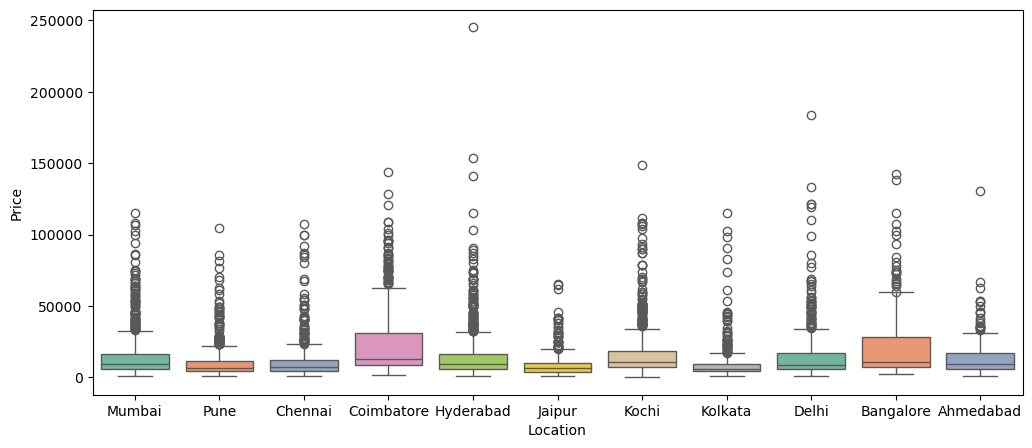

In [ ]:
# Location별 Price
fig, axes = plt.subplots(figsize=(12,5))
sns.boxplot(data = df, y="Price", x="Location", palette="Set2")

In [ ]:
#
pivot_table = df.pivot_table(index='Location', columns='Brand_level', values="Price", aggfunc='count')

pivot_table['high_ratio'] = (pivot_table['high'] / pivot_table.sum(axis=1)).round(3)
pivot_table['low_ratio'] = (pivot_table['low'] / pivot_table.sum(axis=1)).round(3)
pivot_table['middlehigh_ratio'] = (pivot_table['middle_high'] / pivot_table.sum(axis=1)).round(3)
pivot_table['middlelow_ratio'] = (pivot_table['middle_low'] / pivot_table.sum(axis=1)).round(3)

pivot_table

Brand_level,high,low,middle_high,middle_low,high_ratio,low_ratio,middlehigh_ratio,middlelow_ratio
Location,,,,,,,,
Ahmedabad,35,11,39,148,0.150,0.047,0.167,0.634
Bangalore,100,18,55,192,0.274,0.049,0.151,0.525
Chennai,62,39,83,322,0.123,0.077,0.164,0.636
Coimbatore,161,38,104,361,0.242,0.057,0.157,0.543
Delhi,103,11,127,331,0.180,0.019,0.222,0.578
Hyderabad,117,42,127,473,0.154,0.055,0.167,0.623
Jaipur,23,39,52,310,0.054,0.092,0.123,0.731
Kochi,115,32,90,439,0.170,0.047,0.133,0.649
Kolkata,52,46,62,392,0.094,0.083,0.112,0.710


    - location별 가격대별 차량 수의 비율에 차이가 있음
    - 모델링 과정에서 변수 선택 여부 결정

### Fuel_Type

<Axes: xlabel='Fuel_Type', ylabel='Price'>

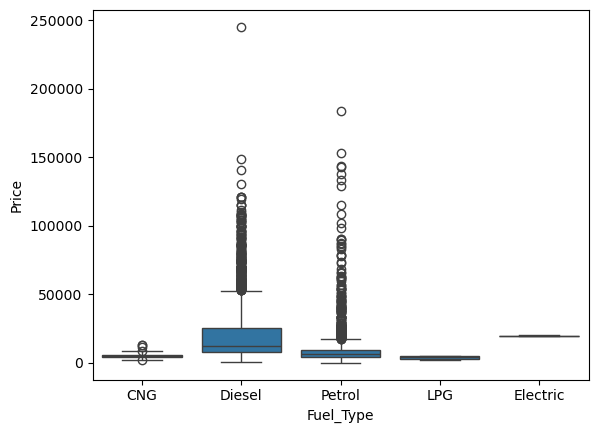

In [ ]:
sns.boxplot(data=df,x='Fuel_Type',y='Price')

    - 전기차만 가격이 높고 나머지는 크게 차이가 없어 보인다.

In [ ]:
# ANOVA test

### Transmission

<Axes: xlabel='Transmission', ylabel='Price'>

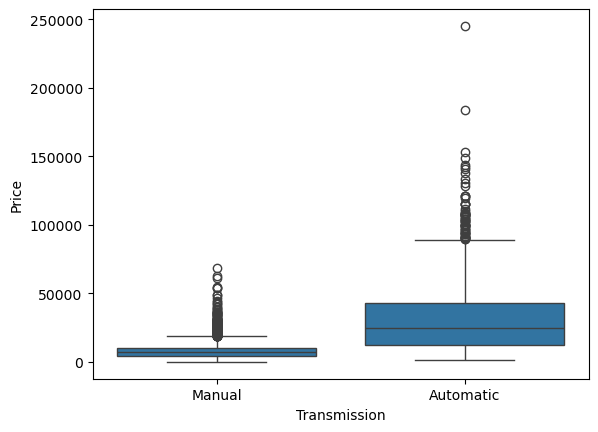

In [ ]:
sns.boxplot(data=df,x='Transmission',y='Price')

- automatic의 가격이 약간 더 높아 보인다.
--> t-test로 확인


In [ ]:
# t-test

## 숫자형 변수

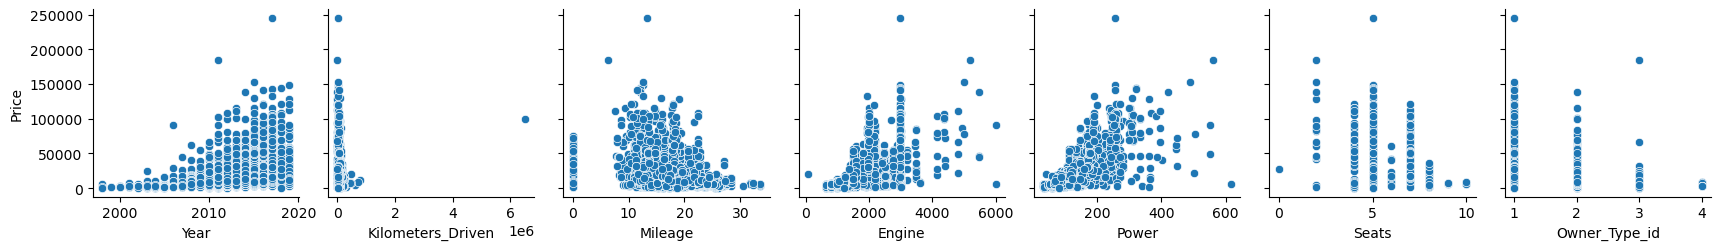

In [ ]:
# 수치형 칼럼만 뽑아냄
num_columns = df.select_dtypes(include=['int','float']).columns
# 목적변수와 수치형설명변수간 산점도
selected_df = df[num_columns]
sns.pairplot(selected_df, y_vars='Price', x_vars=num_columns[1:])

<Axes: >

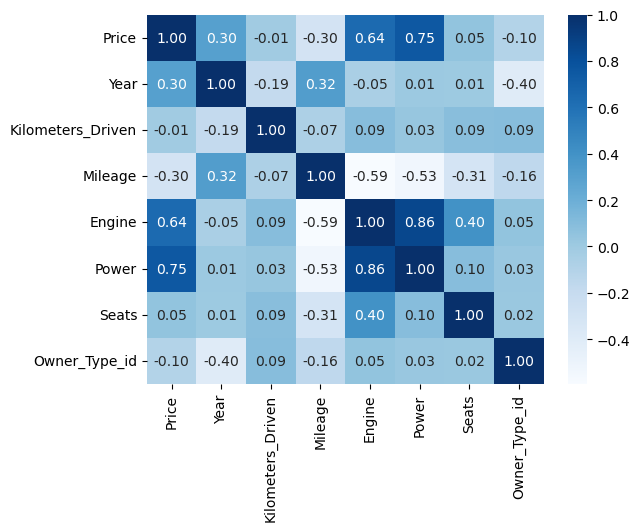

In [ ]:
# 목적-설명 상관계수
num_corr = df[num_columns].corr(method='pearson')
# 상관관계 히트맵
sns.heatmap(num_corr,annot=True,fmt='.2f',cmap='Blues')

### Year
    - Age(연식) 변수 추가(2020년 기준)

<Axes: xlabel='Year', ylabel='Price'>

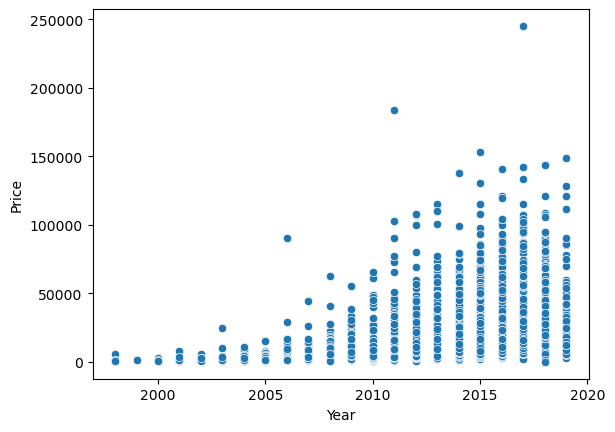

In [ ]:
# year, Price scatter plot
sns.scatterplot(data=df, x="Year", y="Price")

    - 새 차일수록 가격이 높은 경향이 있음
    - Price가 비슷한 시기에 측정된 것으로 추측됨.
    - 따라서 회귀분석에 적절한 'age' feature를 추가함.

In [ ]:
# Age 추가
df['Age'] = 2020 - df['Year']
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,Maruti,1.0,India,middle_low,10
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,Hyundai,1.0,Korea,middle_low,5
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,Honda,1.0,Japan,middle_low,9
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,Maruti,1.0,India,middle_low,8
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,Audi,2.0,Europe,high,7


<Axes: xlabel='Age', ylabel='Price'>

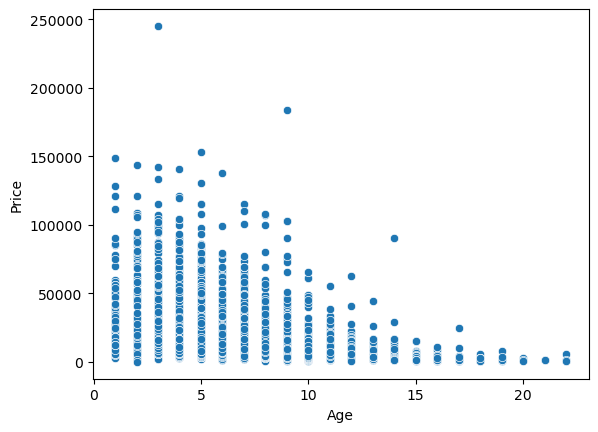

In [ ]:
# year, Price scatter plot
sns.scatterplot(data=df, x="Age", y="Price")

### New_Price

In [ ]:
# New_price 결측치 비율
print(((df["New_Price"].isnull().sum() / len(df))*100).round(2), "%")

86.13 %


    -  결측치 비율이 약 86%로 매우 높아서 변수 자체를 분석에서 제외

In [ ]:
# New_Price 제거
df = df.drop(columns = "New_Price")

In [ ]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,1.0,India,middle_low,10
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,1.0,Korea,middle_low,5
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,1.0,Japan,middle_low,9
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,1.0,India,middle_low,8
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,2.0,Europe,high,7


### Kilometers_Driven

<Axes: xlabel='Kilometers_Driven', ylabel='Count'>

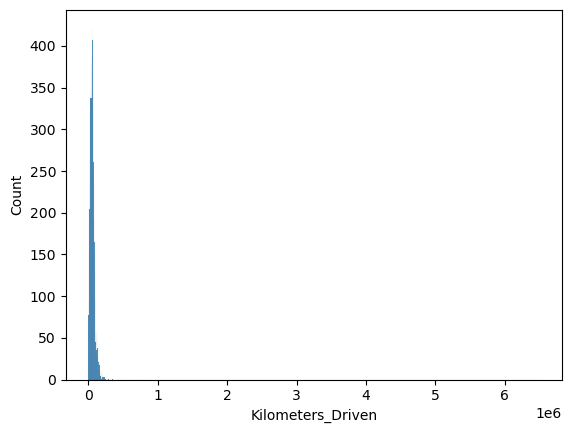

In [ ]:
sns.histplot(data=df, x= df["Kilometers_Driven"])

- 이상치로 보이는 자료 때문에 히스토그램이 명확하지 않다.

In [ ]:
df.shape

(7253, 17)

In [ ]:
df.loc[df["Kilometers_Driven"]>1000000]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
2328,BMW X5 xDrive 30d M Sport,Chennai,99642.4,2017,6500000,Diesel,Automatic,First,15.97,2993.0,258.0,5.0,BMW,1.0,Europe,high,3


- 주행거리가 650만 km인 데이터 존재
- 차종을 고려하였을 때, Price가 거의 신차 가격과 비슷하다,
- 차종과 Price를 고려하면 주행거리가 650만 km인 것은 신뢰할 수 없다,
- 따라서 데이터를 제거한다.

In [ ]:
df.drop(index = 2328, axis=0, inplace=True)

<Axes: xlabel='Kilometers_Driven', ylabel='Count'>

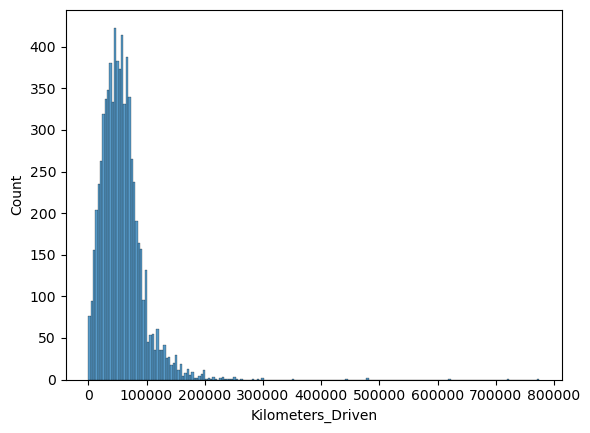

In [ ]:
sns.histplot(data=df, x= df["Kilometers_Driven"])

- right skewed --> 회귀모델 적합시 Scailing 필요

-0.16722624514413656


<Axes: xlabel='Kilometers_Driven', ylabel='Price'>

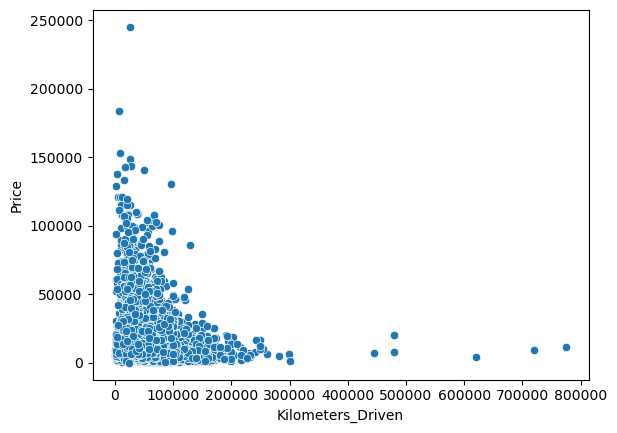

In [ ]:
# 상관계수, 산점도 price ~ kilometer - price
print(df['Kilometers_Driven'].corr(df['Price']))
sns.scatterplot(data = df, x="Kilometers_Driven", y="Price")

- 상관계수는 작지만
- scatterplot을 봤을 때 음의 관계가 있어 보인다,

### Engine
    - 46개 결측치 직접 차량 정보 찾아서 입력

corr = 0.6397239922164707


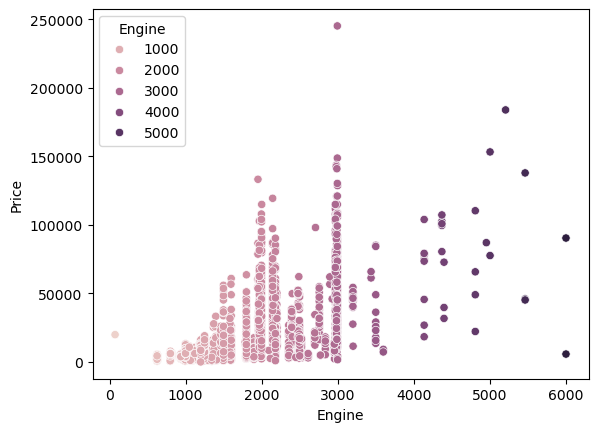

In [ ]:
# 종속변수와의 관계
sns.scatterplot(data=df, x="Engine", y="Price", hue="Engine")
print("corr =",df['Engine'].corr(df['Price']))

- 엔진의 배기량이 클 수록 가격이 높아지는 경향이 있다.
- 결측치 제거 전 corr 0.640
- Engine의 최대치는 약 6000으로 이상치는 보이지 않는다.

In [ ]:
# 결측치 인덱스
df[df['Engine'].isnull()].index

Int64Index([ 194,  208,  733,  749, 1294, 1327, 1385, 1460, 2074, 2096, 2264,
            2325, 2335, 2530, 2542, 2623, 2668, 2737, 2780, 2842, 3272, 3404,
            3520, 3522, 3810, 4011, 4152, 4229, 4577, 4604, 4697, 4712, 4952,
            5015, 5185, 5270, 6042, 6541, 6544, 6633, 6643, 6651, 6677, 6685,
            6880, 6902],
           dtype='int64')

In [ ]:
# 직접 찾은 Engine, Power data
idx_ls = df[df['Engine'].isnull()].index
engine_ls = [1497, 1197, 1197, 2993, 1497, 1197, 1493, 2993, 1248, 999,
             1197, 1197, 1298, 1995, 999, 1995, 1197, 1061, 999, 999, 1995,
             1298, 1995, 999, 2354, 1248, 3000, 1086, 1995, 1198, 1172, 1086, 1368,
             1298, 1197, 1493, 1798, 1364, 1396, 2179, 1995, 1197, 1368, 1298,
             1995, 1197]
power_ls = [77, 83, 83, 242,98, 83, 100, 241, 75, 62, 80, 83, 87, 181, 62, 181, 85, 67, 210,
            62, 174, 87, 184, 62, 200, 76, 175, 210, 188, 90, 67, 62, 89, 89, 85, 100,
            158, 68, 99, 120, 175, 83, 90, 87, 177, 80]

In [ ]:
# 결측치 채우기
for idx in range(len(idx_ls)):
    df.loc[idx_ls[idx],["Engine", "Power"]] = np.array([engine_ls[idx], power_ls[idx]])

In [ ]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Power                 129
Seats                  53
Brand                   0
Owner_Type_id           0
Brand_Country           0
Brand_level             0
Age                     0
dtype: int64

corr = 0.6407132277306331


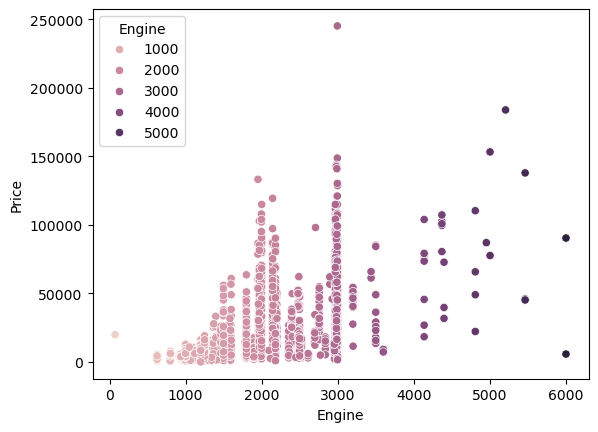

In [ ]:
# 종속변수와의 관계
sns.scatterplot(data=df, x="Engine", y="Price", hue="Engine")
print("corr =", df['Engine'].corr(df['Price']))

### Seats

In [ ]:
## Seats 결측치 채우기
# Land Rover 7인승
# Mahindra TUV 300 P4 7인승
# 나머지 5인승

df.loc[df['Name'].str.contains('Land Rover'), 'Seats'] = 7
df.loc[df['Name'].str.contains('Mahindra'), 'Seats'] = 7
df['Seats'].fillna(5, inplace=True)

In [ ]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Power                 129
Seats                   0
Brand                   0
Owner_Type_id           0
Brand_Country           0
Brand_level             0
Age                     0
dtype: int64

### Power
    - Power ~ Engine 선형회귀 적합하여 결측치 대체

<Axes: xlabel='Power', ylabel='Count'>

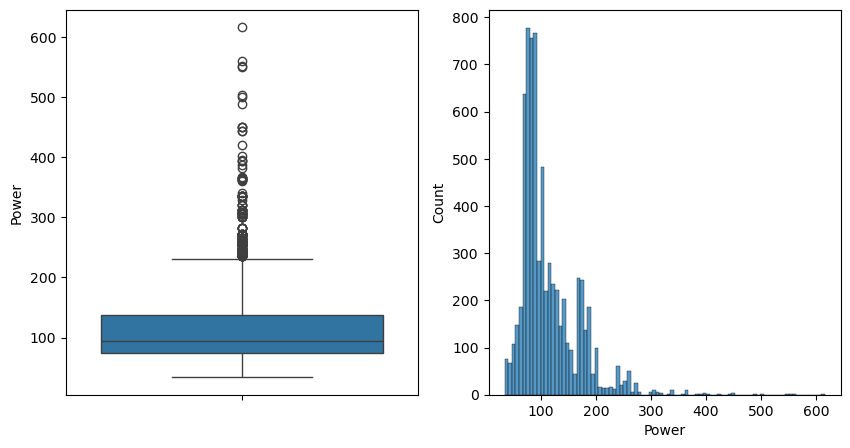

In [ ]:
# plotting
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

plt.subplot(121)
sns.boxplot(data=df, y= 'Power')

plt.subplot(122)
sns.histplot(data=df, x = 'Power')

Power 분석

분석내용~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    - right-skewed: 회귀분석 시 scailing 필요

<Axes: xlabel='Power', ylabel='Engine'>

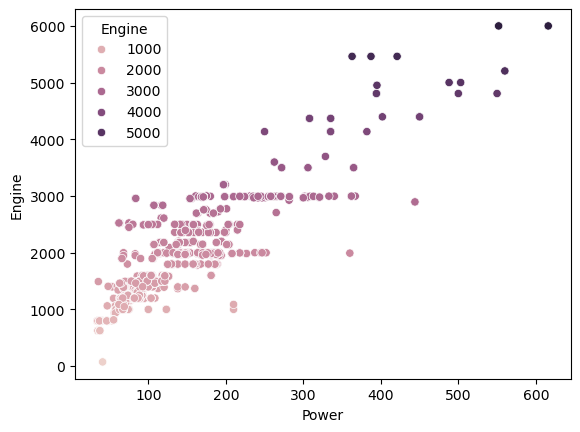

In [ ]:
# Power와 Engine 관계
sns.scatterplot(data = df, x = "Power", y="Engine", hue="Engine")

/tmp/ipykernel_14253/2378859865.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

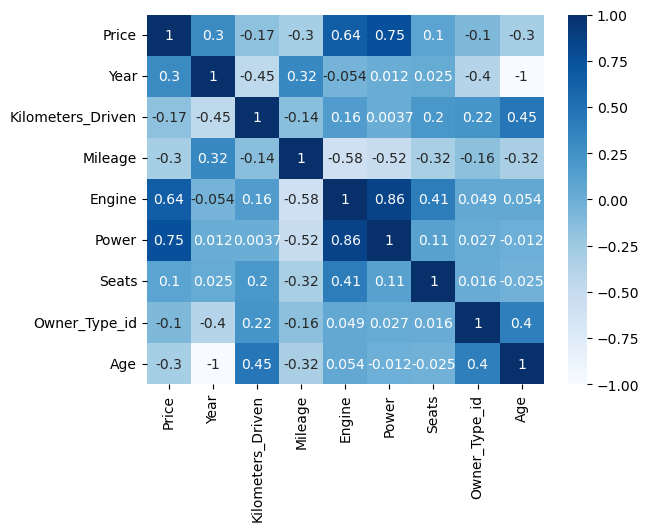

In [ ]:
df_corr = df.corr()
sns.heatmap(data = df_corr, annot=True, cmap="Blues")

- Power와 Engine의 상관계수 = 0.86
- 매우 강한 선형관계가 있다고 판단.
- Power ~ Engine의 1차 선형회귀를 통해 결측치 대체.

In [ ]:
# Power가 null인 dataframe
power_null_idx = df[df["Power"].isnull()].index
df_Engine_power_null = df.loc[~df.index.isin(power_null_idx), ['Engine']]
df_Power_power_null = df.loc[~df.index.isin(power_null_idx), ['Power']]
df_Engine_linear = df.loc[power_null_idx, ['Engine']]

In [ ]:
# 회귀 적합
linear_model = LinearRegression()
linear_model.fit(df_Engine_power_null,df_Power_power_null)
Power_linear = linear_model.predict(df_Engine_linear)
df.loc[power_null_idx, "Power"] = Power_linear

In [ ]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Power                   0
Seats                   0
Brand                   0
Owner_Type_id           0
Brand_Country           0
Brand_level             0
Age                     0
dtype: int64

corr = 0.7538129662043411


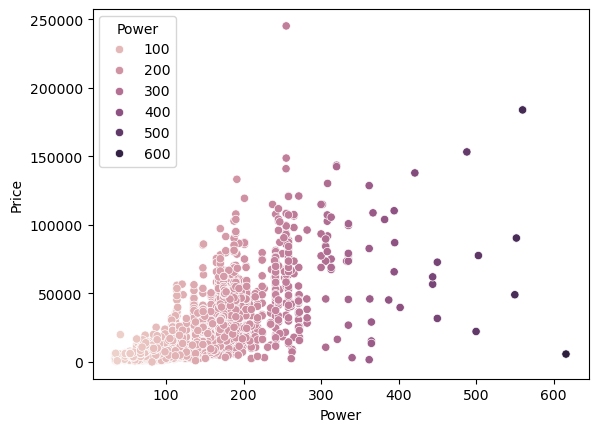

In [ ]:
# power - price 산점도, 상관계수
# 종속변수와의 관계
sns.scatterplot(data=df, x="Power", y="Price", hue="Power")
print("corr =", df['Power'].corr(df['Price']))

- 상관계수 = 0.754로 높고
- 산점도로 봐도 양의 관계가 보인다.
- Power가 Price를 설명하는 중요한 변수라고 생각할 수 있다.

### Owner_Type_id

<Axes: xlabel='Owner_Type_id', ylabel='Price'>

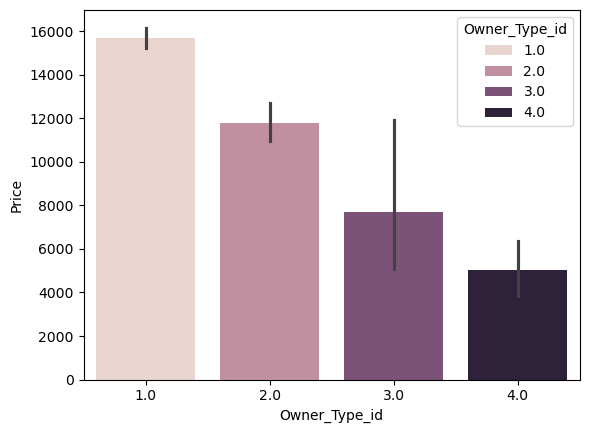

In [ ]:
# first Owner가 압도적으로 많아 fourth 이상은 측정되지 않음.
sns.barplot(data = df, x= 'Owner_Type_id', y="Price", hue="Owner_Type_id")

- 주인을 거친 횟수가 많을 수록 Price가 낮아지는 것을 barplot을 통해 확인할 수 있다.

### Mileage
    - 결측값을 0으로 대체
    - 상관관계가 높은 Engine(Diesel, Petrol)을 이용하여 회귀적합하여 0인 값 대체

In [ ]:
# null값인 Mileage
df[df['Mileage'].isnull()]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
4446,Mahindra E Verito D4,Chennai,19928.48,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,7.0,Mahindra,1.0,India,middle_high,4
4904,Toyota Prius 2009-2016 Z4,Mumbai,19545.24,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,Toyota,1.0,Japan,middle_high,9


- 전기차라 연비가 없음 --> 0으로 처리

In [ ]:
# 0으로 들어간 Mileage
df[df["Mileage"]==0]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
14,Land Rover Freelander 2 TD4 SE,Pune,26826.80,2012,85000,Diesel,Automatic,Second,0.0,2179.0,115.000000,7.0,Land,2.0,Europe,high,8
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,54680.68,2019,15369,Diesel,Automatic,First,0.0,1950.0,194.000000,5.0,Mercedes-Benz,1.0,Europe,high,1
79,Hyundai Santro Xing XL,Hyderabad,1992.85,2005,87591,Petrol,Manual,First,0.0,1086.0,71.584186,5.0,Hyundai,1.0,Korea,middle_low,15
194,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.0,1497.0,77.000000,5.0,Honda,1.0,Japan,middle_low,13
229,Ford Figo Diesel,Bangalore,5518.66,2015,70436,Diesel,Manual,First,0.0,1498.0,99.000000,5.0,Ford,1.0,US,middle_low,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6633,Mahindra TUV 300 P4,Kolkata,NaN,2016,27000,Diesel,Manual,First,0.0,2179.0,120.000000,7.0,Mahindra,1.0,India,middle_high,4
6697,Hyundai Santro Xing XL,Jaipur,NaN,2007,85000,Petrol,Manual,Second,0.0,1086.0,71.584186,5.0,Hyundai,2.0,Korea,middle_low,13
6857,Land Rover Freelander 2 TD4 SE,Mumbai,NaN,2011,87000,Diesel,Automatic,First,0.0,2179.0,115.000000,7.0,Land,1.0,Europe,high,9
6957,Honda Jazz 2020 Petrol,Kochi,NaN,2019,11574,Petrol,Manual,First,0.0,1199.0,88.700000,5.0,Honda,1.0,Japan,middle_low,1


In [ ]:
# Mileage 결측값 0으로 채우기
df.loc[4446, "Mileage"] = 0
df.loc[4904, "Mileage"] = 0

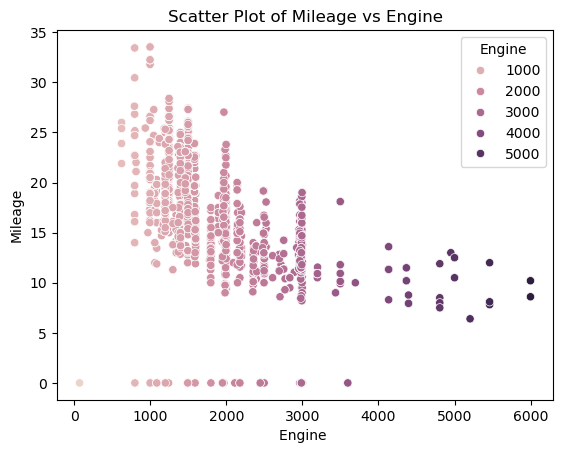

In [ ]:
# Mileage, Engine 관계(상관계수 0.59)
sns.scatterplot(x='Engine', y='Mileage', data=df, hue='Engine')

plt.title('Scatter Plot of Mileage vs Engine')
plt.xlabel('Engine ')
plt.ylabel('Mileage')

plt.legend(title='Engine')

plt.show()

<Axes: xlabel='Fuel_Type', ylabel='Mileage'>

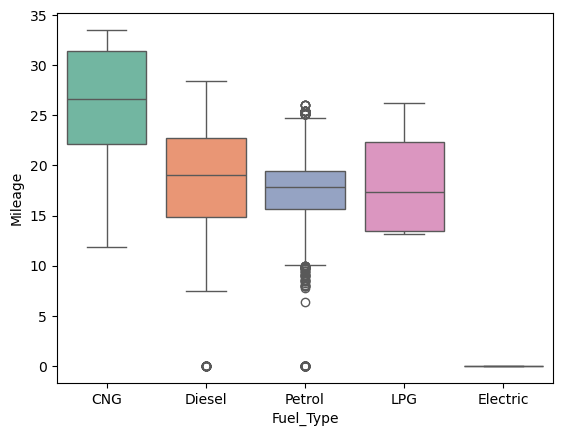

In [ ]:
# 연료별 Mileage
sns.boxplot(x='Fuel_Type', y='Mileage', data=df, hue = "Fuel_Type", palette="Set2")

- Mileage와 Engine의 상관관계는 -0.59
- 결측값(0)이 있는 부분만 생각하면 더 강한 선형성을 띈다.
- 경유차와 휘발유차의 연비가 차이가 있음을 고려
- 경유차와 휘발유차를 구분하여 Mileage ~ Engine 선형회귀를 통해 결측치 대체

In [ ]:
## Diesel
# Mileage가 0인 dataframe
Diesel_Mileage_null_idx = df.loc[(df["Mileage"]==0) & (df["Fuel_Type"]=="Diesel") ].index      ## Diesel & Mileage =0인 idx
df_Engine_Diesel_Mileage_notnull = df.loc[~df.index.isin(Diesel_Mileage_null_idx), ['Engine']]    ## Diesel & Mileage =0인걸 제외한 Engine
df_Mileage_Diesel_Mileage_notnull = df.loc[~df.index.isin(Diesel_Mileage_null_idx), ['Mileage']]  ## Diesel & Mileage =0인걸 제외한 Mileage
df_Engine_linear_Mileage_null = df.loc[Diesel_Mileage_null_idx, ['Engine']]  ## Diesel & Mileage =0인 Engine

In [ ]:
# Mileage_Diesel 회귀 적합
linear_model_Diesel = LinearRegression()
linear_model_Diesel.fit(y = df_Mileage_Diesel_Mileage_notnull, X = df_Engine_Diesel_Mileage_notnull)
Mileage_Diesel_linear = linear_model_Diesel.predict(df_Engine_linear_Mileage_null)
df.loc[Diesel_Mileage_null_idx, "Mileage"] = Mileage_Diesel_linear

In [ ]:
## Petrol
# Mileage가 0인 dataframe
Petrol_Mileage_null_idx = df.loc[(df["Mileage"]==0) & (df["Fuel_Type"]=="Petrol") ].index      ## Petrol & Mileage =0인 idx
df_Engine_Petrol_Mileage_notnull = df.loc[~df.index.isin(Petrol_Mileage_null_idx), ['Engine']]    ## Petrol & Mileage =0인걸 제외한 Engine
df_Mileage_Petrol_Mileage_notnull = df.loc[~df.index.isin(Petrol_Mileage_null_idx), ['Mileage']]  ## Petrol & Mileage =0인걸 제외한 Mileage
df_Engine_linear_Mileage_null = df.loc[Petrol_Mileage_null_idx, ['Engine']]  ## Petrol & Mileage =0인 Engine

In [ ]:
# Mileage_Petrol 회귀 적합
linear_model_Petrol = LinearRegression()
linear_model_Petrol.fit(X = df_Engine_Petrol_Mileage_notnull, y = df_Mileage_Petrol_Mileage_notnull)
Mileage_Petrol_linear = linear_model_Petrol.predict(df_Engine_linear_Mileage_null)
df.loc[Petrol_Mileage_null_idx, "Mileage"] = Mileage_Petrol_linear

In [ ]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,1.0,India,middle_low,10
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,1.0,Korea,middle_low,5
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,1.0,Japan,middle_low,9
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,1.0,India,middle_low,8
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,2.0,Europe,high,7


corr = -0.3300250188556866


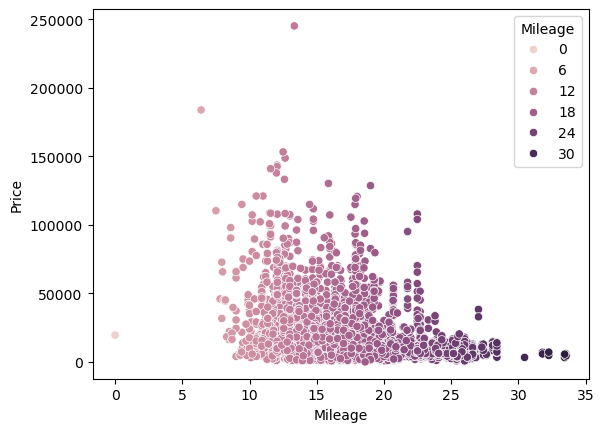

In [ ]:
# price ~ mileage 산점도 상관계수

sns.scatterplot(data=df, x="Mileage", y="Price", hue="Mileage")
print("corr =", df['Mileage'].corr(df['Price']))

- Price와 mileage의 상관게수 = -0.33
- scatterplot을 보면 강하지는 않지만 음의 관계를 갖는다는 것을 확인할 수 있다.
- Mileage = 0은 전기차

## 설명변수간 관계

In [ ]:
# 수치형 칼럼만 뽑아냄
num_columns = df.select_dtypes(include=['int','float']).columns

# Data split

In [ ]:
# 목표변수/설명변수 분리
df_raw_x = df.drop("Price", axis = 1, inplace = False)
df_raw_y = df["Price"]

display("설명변수:", df_raw_x.head())
display("목표변수:",df_raw_y.head())

'설명변수:'

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,1.0,India,middle_low,10
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,1.0,Korea,middle_low,5
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,1.0,Japan,middle_low,9
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,1.0,India,middle_low,8
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,2.0,Europe,high,7


'목표변수:'

0     2682.68
1    19162.00
2     6898.32
3     9197.76
4    27194.71
Name: Price, dtype: float64

In [ ]:
# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char = df_raw_x.select_dtypes(include = "object")
df_raw_x_char.drop(columns=['Name','Owner_Type','Brand_Country','Brand_level'],inplace=True) # Brand를 남김
df_raw_x_char.head()

,Location,Fuel_Type,Transmission,Brand
0,Mumbai,CNG,Manual,Maruti
1,Pune,Diesel,Manual,Hyundai
2,Chennai,Petrol,Manual,Honda
3,Chennai,Diesel,Manual,Maruti
4,Coimbatore,Diesel,Automatic,Audi


In [ ]:
# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy = pd.get_dummies(df_raw_x_char)
df_x_dummy.head()

display("Dummy 변환 전:", df_raw_x_char.head())
display("Dummy 변환 후:",df_x_dummy.head())

'Dummy 변환 전:'

,Location,Fuel_Type,Transmission,Brand
0,Mumbai,CNG,Manual,Maruti
1,Pune,Diesel,Manual,Hyundai
2,Chennai,Petrol,Manual,Honda
3,Chennai,Diesel,Manual,Maruti
4,Coimbatore,Diesel,Automatic,Audi


'Dummy 변환 후:'

,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,...,Brand_Nissan,Brand_OpelCorsa,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")
df_raw_x_num.drop(columns=['Year',],inplace=True)
df_raw_x_num

# 변수명 저장
v_feature_names = df_raw_x_num.columns

In [ ]:
from sklearn.preprocessing import StandardScaler
# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names,index=df_raw_x_num.index)


In [ ]:
df_x_scaled

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age
0,0.378408,1.984952,-1.038739,-1.018576,-0.362272,-0.441328,1.034026
1,-0.448326,0.320255,-0.056761,0.258055,-0.362272,-0.441328,-0.502478
2,-0.314982,-0.032862,-0.700764,-0.445555,-0.362272,-0.441328,0.726725
3,0.778441,0.584493,-0.618372,-0.444430,2.115044,-0.441328,0.419424
4,-0.457127,-0.753510,0.592286,0.531995,-0.362272,1.747804,0.112123
...,...,...,...,...,...,...,...
7248,0.842739,0.529243,-0.029858,-0.165987,-0.362272,-0.441328,0.726725
7249,0.031713,-0.270676,-0.704127,-0.165987,-0.362272,-0.441328,-0.502478
7250,-0.795021,1.139392,-0.260219,-0.925887,-0.362272,-0.441328,0.419424
7251,-0.147981,-0.273078,-0.704127,-0.165987,-0.362272,3.936936,0.112123


In [ ]:
display("원래 설명변수:", df_raw_x.head(3))

# 원래 연속형(df_raw_x_num) + 원래 범주형(df_raw_x_char)
df_x_raw_raw = df_raw_x_num.join(df_raw_x_char)
display("원래 연속형+ 원래 범주형...회귀분석용: ", df_x_raw_raw.head(3))

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 설명변수:'

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,1.0,India,middle_low,10
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,1.0,Korea,middle_low,5
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,1.0,Japan,middle_low,9


'원래 연속형+ 원래 범주형...회귀분석용: '

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location,Fuel_Type,Transmission,Brand
0,72000,26.60,998.0,58.16,5.0,1.0,10,Mumbai,CNG,Manual,Maruti
1,41000,19.67,1582.0,126.20,5.0,1.0,5,Pune,Diesel,Manual,Hyundai
2,46000,18.20,1199.0,88.70,5.0,1.0,9,Chennai,Petrol,Manual,Honda


'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Brand_Nissan,Brand_OpelCorsa,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,72000,26.60,998.0,58.16,5.0,1.0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,41000,19.67,1582.0,126.20,5.0,1.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,46000,18.20,1199.0,88.70,5.0,1.0,9,0,0,1,...,0,0,0,0,0,0,0,0,0,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Brand_Nissan,Brand_OpelCorsa,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,0.378408,1.984952,-1.038739,-1.018576,-0.362272,-0.441328,1.034026,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.448326,0.320255,-0.056761,0.258055,-0.362272,-0.441328,-0.502478,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.314982,-0.032862,-0.700764,-0.445555,-0.362272,-0.441328,0.726725,0,0,1,...,0,0,0,0,0,0,0,0,0,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location,Fuel_Type,Transmission,Brand
0,0.378408,1.984952,-1.038739,-1.018576,-0.362272,-0.441328,1.034026,Mumbai,CNG,Manual,Maruti
1,-0.448326,0.320255,-0.056761,0.258055,-0.362272,-0.441328,-0.502478,Pune,Diesel,Manual,Hyundai
2,-0.314982,-0.032862,-0.700764,-0.445555,-0.362272,-0.441328,0.726725,Chennai,Petrol,Manual,Honda


In [ ]:
submission_dummy = df_x_raw_dummy.loc[df_raw_y[df_raw_y.isnull()].index]
df_x_raw_dummy_sub = df_x_raw_dummy.drop(submission_dummy.index)
df_raw_y_dummy = df_raw_y.drop(submission_dummy.index)

df_x_raw_raw_sub = df_x_raw_raw.drop(submission_dummy.index)

# 원래 연속형 + 원래 범주형
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_raw_raw_sub, df_raw_y_dummy
                                    , test_size = 0.3, random_state = 1234)
display("원래 연속형+ 원래 범주형...회귀분석 용:", df_train_x.head())

# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy_sub, df_raw_y_dummy
                                    , test_size = 0.3, random_state = 1234)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())


submission_sd = df_x_raw_dummy.loc[df_raw_y[df_raw_y.isnull()].index]
df_x_raw_sd_sub = df_x_scale_dummy.drop(submission_sd.index)
df_raw_y_sd = df_raw_y.drop(submission_sd.index)

# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_raw_sd_sub, df_raw_y_sd
                                    , test_size = 0.3, random_state = 1234)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

submission_reg = df_x_scale_raw.loc[df_raw_y[df_raw_y.isnull()].index]
df_x_raw_reg_sub = df_x_scale_raw.drop(submission_reg.index)
df_raw_y_reg = df_raw_y.drop(submission_reg.index)

# 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_raw_reg_sub, df_raw_y_reg
                                    , test_size = 0.3, random_state = 1234)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'원래 연속형+ 원래 범주형...회귀분석 용:'

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location,Fuel_Type,Transmission,Brand
5226,140000,15.10,2179.0,140.00,7.0,2.0,7,Hyderabad,Diesel,Manual,Mahindra
2927,30000,23.10,998.0,67.04,5.0,2.0,4,Jaipur,Petrol,Automatic,Maruti
475,64284,17.72,1968.0,108.49,5.0,1.0,8,Kolkata,Diesel,Manual,Skoda
2814,54540,17.50,1298.0,85.80,5.0,3.0,11,Mumbai,Petrol,Manual,Maruti
436,34267,22.74,796.0,47.30,5.0,1.0,4,Kochi,Petrol,Manual,Maruti


'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Brand_Nissan,Brand_OpelCorsa,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
5226,140000,15.10,2179.0,140.00,7.0,2.0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2927,30000,23.10,998.0,67.04,5.0,2.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
475,64284,17.72,1968.0,108.49,5.0,1.0,8,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2814,54540,17.50,1298.0,85.80,5.0,3.0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
436,34267,22.74,796.0,47.30,5.0,1.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Brand_Nissan,Brand_OpelCorsa,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
5226,2.191889,-0.777532,0.947076,0.516984,2.115044,1.747804,0.112123,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2927,-0.741683,1.144196,-1.038739,-0.851961,-0.362272,1.747804,-0.809779,0,0,0,...,0,0,0,0,0,0,0,0,0,0
475,0.172631,-0.148166,0.592286,-0.074236,-0.362272,-0.441328,0.419424,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2814,-0.087230,-0.201013,-0.534298,-0.499968,-0.362272,3.936936,1.341326,0,0,0,...,0,0,0,0,0,0,0,0,0,0
436,-0.627887,1.057718,-1.378396,-1.222342,-0.362272,-0.441328,-0.809779,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location,Fuel_Type,Transmission,Brand
5226,2.191889,-0.777532,0.947076,0.516984,2.115044,1.747804,0.112123,Hyderabad,Diesel,Manual,Mahindra
2927,-0.741683,1.144196,-1.038739,-0.851961,-0.362272,1.747804,-0.809779,Jaipur,Petrol,Automatic,Maruti
475,0.172631,-0.148166,0.592286,-0.074236,-0.362272,-0.441328,0.419424,Kolkata,Diesel,Manual,Skoda
2814,-0.087230,-0.201013,-0.534298,-0.499968,-0.362272,3.936936,1.341326,Mumbai,Petrol,Manual,Maruti
436,-0.627887,1.057718,-1.378396,-1.222342,-0.362272,-0.441328,-0.809779,Kochi,Petrol,Manual,Maruti


# Modeling

## Regression
    -

### fit & train
    - backward elimination을 통해 회귀계수를 선택한다.

In [ ]:
df_train_rg = pd.concat([df_train_y, df_train_x], axis=1)
df_test_rg = pd.concat([df_test_y, df_test_x], axis=1)

print(df_train_rg.shape)
print(df_test_rg.shape)

(4339, 12)
(1860, 12)


In [ ]:
df_train_rg.columns

Index(['Price', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Owner_Type_id', 'Age', 'Location', 'Fuel_Type', 'Transmission',
       'Brand'],
      dtype='object')

In [ ]:
reg_model = smf.ols(formula = "Price~ C(Location) + C(Brand) + C(Fuel_Type) + C(Transmission) +\
 Kilometers_Driven + Mileage + Engine + Power + Seats + Owner_Type_id + Age", data = df_train_rg)
reg_result = reg_model.fit()

print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     277.9
Date:                Sat, 09 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:33:18   Log-Likelihood:                -45400.
No. Observations:                4339   AIC:                         9.090e+04
Df Residuals:                    4288   BIC:                         9.123e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [ ]:
# ## VIF
# # 상수항 추가
# X_train_const = add_constant(X_train)  #### 숫자형 변수만 있는 X_train 넣어서 VIF
# # vif dataframe 만들기
# df_vif = pd.DataFrame()
# df_vif['variable'] = X_train.columns
# df_vif["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
# df_vif.sort_values("VIF", ascending=False).round(2)

    - Mileage의 p-value = 0.823 > 0.05
    - 유의수준 5% 하에서 유의하지 않으므로 제거한다.

In [ ]:
# reg_model = smf.ols(formula = "Price~ C(Location) + C(Brand) + C(Fuel_Type) + C(Transmission) +\
#  Kilometers_Driven + Engine + Power + Seats + Owner_Type_id + Age", data = data)
# reg_result = reg_model.fit()
# print(reg_result.summary())

    - Transmission[T.Manual]의 p-value = 0.298 > 0.05
    - 유의수준 5% 하에서 유의하지 않으므로 제거한다.

In [ ]:
# reg_model = smf.ols(formula = "Price~ C(Location) + C(Brand) + C(Fuel_Type) +\
#  Kilometers_Driven + Engine + Power + Seats + Owner_Type_id + Age", data = data)
# reg_result = reg_model.fit()
# print(reg_result.summary())

- 유의하지 않은 변수가 없다.
- train set에 대한 R-square = 0.754 / adjusted R-square = 0.752
-

### 가정 확인
    - 정규성
    - 등분산성

### predict & evaluation

## Decision tree

### fit & train

In [ ]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# export_graphviz: 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz
# 예측/회귀 Decision Tree
from sklearn.tree import DecisionTreeRegressor
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

In [ ]:
tree_uncustomized = DecisionTreeRegressor()
tree_uncustomized.fit (df_train_x_rd, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x_rd, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x_rd, df_test_y)))

Score on training set: 1.000
Score on test set: 0.778


In [ ]:
tree_uncustomized.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## 잎사귀 노드 최소 자료 수(MinSamplesLeaf)

In [ ]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = [ ]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf = [n_leaf for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x_rd, df_train_y)
    train_score.append(tree.score(df_train_x_rd, df_train_y))
    test_score.append(tree.score(df_test_x_rd, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [ ]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.785
1,2,0.972,0.737
2,3,0.951,0.773
3,4,0.921,0.816
4,5,0.911,0.836
5,6,0.901,0.825
6,7,0.892,0.791
7,8,0.884,0.794
8,9,0.880,0.788
9,10,0.873,0.803


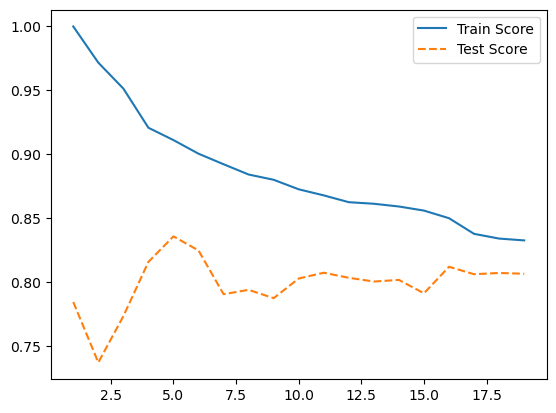

In [ ]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.legend()

5 선택

## 최대 깊이(MAX_DEPTH)

In [ ]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 20)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(min_samples_leaf=5, max_depth = v_max_depth)
    tree.fit(df_train_x_rd, df_train_y)
    train_score.append(tree.score(df_train_x_rd, df_train_y))
    test_score.append(tree.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

In [ ]:
#  모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.486,0.488
1,2,0.605,0.613
2,3,0.723,0.727
3,4,0.783,0.760
4,5,0.830,0.803
5,6,0.861,0.809
6,7,0.877,0.824
7,8,0.891,0.828
8,9,0.901,0.834
9,10,0.906,0.837


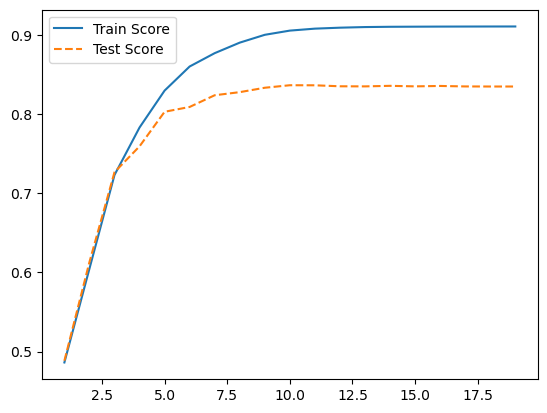

In [ ]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.legend()

test 정확도 고려하여 9 선택

## 분리 노드의 최소 자료수(MinSamplesSplit)

In [ ]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분리 노드의 최소 자료 수
para_split = [n_split * 2 for n_split in range(1, 50)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(max_depth=9, min_samples_leaf=5
                                 , min_samples_split=v_min_samples_split )
    tree.fit(df_train_x_rd, df_train_y)
    train_score.append(tree.score(df_train_x_rd, df_train_y))
    test_score.append(tree.score(df_test_x_rd, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

In [ ]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.901,0.834
1,4,0.901,0.834
2,6,0.901,0.834
3,8,0.901,0.834
4,10,0.901,0.834
5,12,0.898,0.832
6,14,0.898,0.832
7,16,0.897,0.832
8,18,0.895,0.833
9,20,0.892,0.834


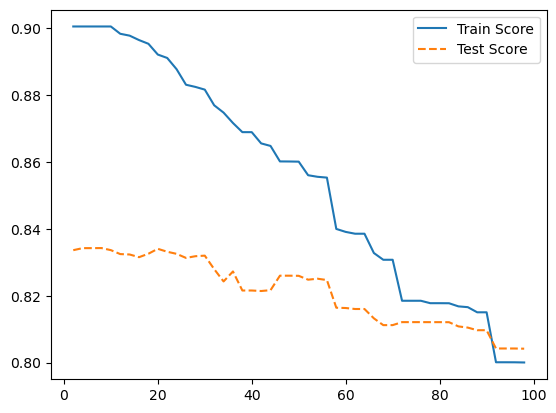

In [ ]:
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.legend()

모델 정확도 및 일반화 성능 고려, 20 선택

### predict & evaluation

In [ ]:
v_feature_name = df_train_x_rd.columns
tree_final = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 20, max_depth = 9)
tree_final.fit(df_train_x_rd, df_train_y)
tree_final.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
tree_final.score(df_train_x_rd, df_train_y)

0.8922000525780369

In [ ]:
tree_final.score(df_test_x_rd, df_test_y)

0.834044303183361

### feature importance

In [ ]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
3,Power,0.714
6,Age,0.185
2,Engine,0.036
1,Mileage,0.020
12,Location_Hyderabad,0.012
0,Kilometers_Driven,0.008
24,Transmission_Manual,0.007
44,Brand_Mercedes-Benz,0.006
45,Brand_Mini,0.002
4,Seats,0.002


Text(0, 0.5, '변수')

/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning:

Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.

/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning:

Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.

/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning:

Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.

/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning:

Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.

/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning:

Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.

/home/piai/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.

/home/piai/anaconda3/lib/python3.10/site-packages/I

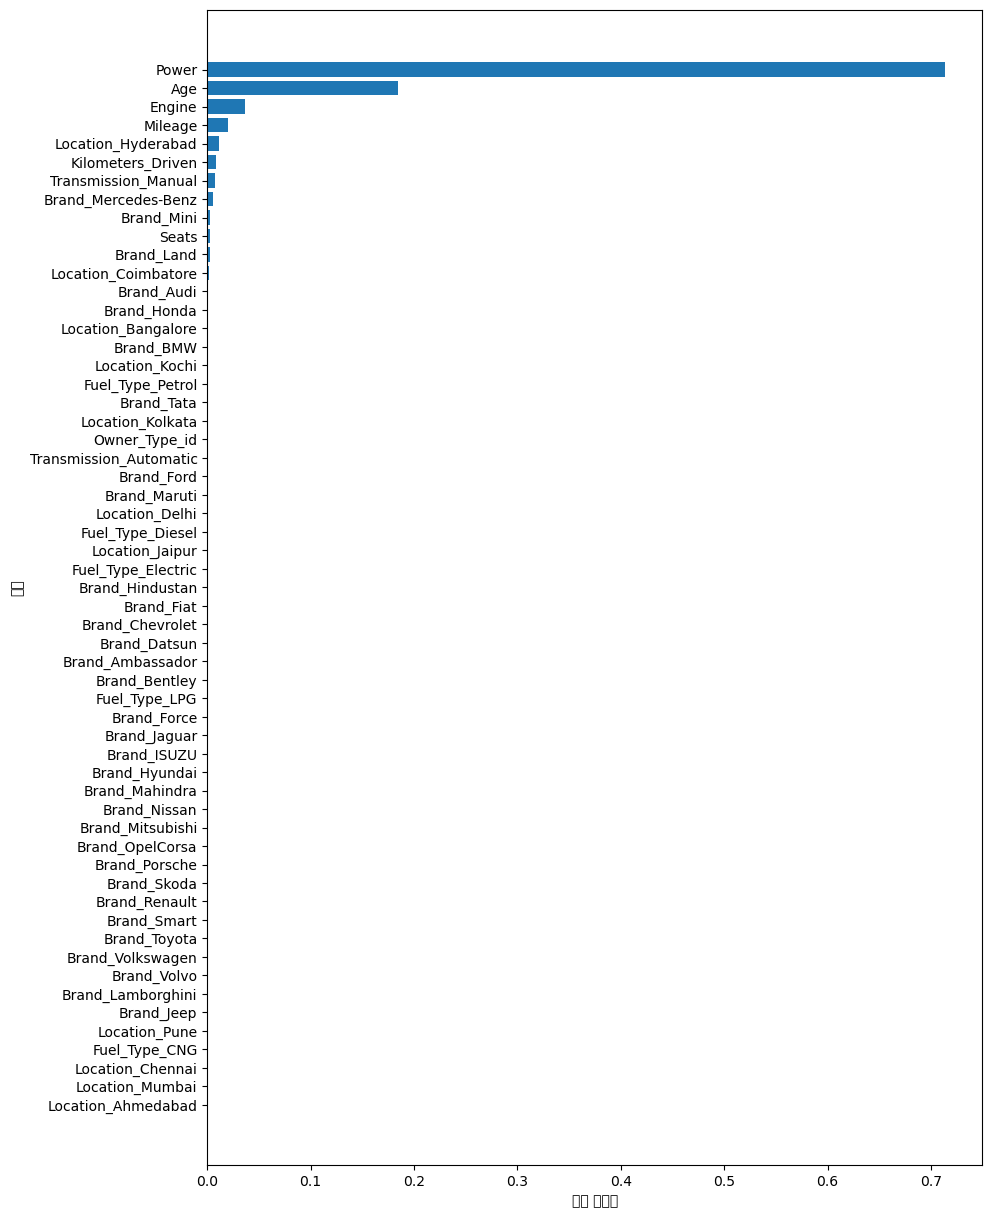

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
fig, axes = plt.subplots(figsize=(10,15))

coordinates = range(len(df_importance))

plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

#### 설명변수 중요도: power> Age> engine > Mileage > Location_Hyderabad > Kilometers_Driven 등 순으로 영향력이 크다ㅡ

### grid search

## Randomforest

### fit & train

### predict & evaluation

### grid search

## Gradient Boosting

### fit & train

### predict & evaluation

### grid search

# 결론

## best model(성능)

## explainable model(설명력)

In [ ]:
df.shape

(7252, 17)

In [ ]:
# GridSearchCV를 이용한 최적 parameter 찾기
estimator = DecisionTreeRegressor()
# 구하고자 하는 parameter와 범위
param_grid = {"criterion": ["mse", "friedman_mse", "mae"], "max_features": ["auto", "sqrt", "log2"],
              "max_depth": para_depth, "min_samples_split": para_split,
              "min_samples_leaf": para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs = -1)
grid_dt.fit(df_train_x_rd, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))